Various variables contribute to the selling price of HDB resale flats in Singapore. Develop a regression model to gauge the impact of factors such as proximity to the CBD and the nearest MRT station, alongside considerations like flat size, floor level, and remaining lease duration, on the selling price of HDB resale flats.

# Step 1: Create SVY21 Converter 

SVY21 is a geodetic datum which is introduced in Singapore whereas WSG84 is standard for GPS. Gooplemap only provides WSG84. 

Below is the Python Class for conversion between SVY21 and WSG84 

In [1]:
#Convert between Lat/Lon, and SVY21
#from https://github.com/cgcai/SVY21

import math
from sys import argv
import csv

class SVY21:
    # Ref: http://www.linz.govt.nz/geodetic/conversion-coordinates/projection-conversions/transverse-mercator-preliminary-computations/index.aspx

    # WGS84 Datum
    a = 6378137
    f = 1 / 298.257223563

    # SVY21 Projection
    # Fundamental point: Base 7 at Pierce Resevoir.
    # Latitude: 1 22 02.9154 N, longitude: 103 49 31.9752 E (of Greenwich).

    # Known Issue: Setting (oLat, oLon) to the exact coordinates specified above
    # results in computation being slightly off. The values below give the most
    # accurate represenation of test data.
    oLat = 1.366666  # origin's lat in degrees
    oLon = 103.833333  # origin's lon in degrees
    oN = 38744.572  # false Northing
    oE = 28001.642  # false Easting
    k = 1  # scale factor

    #
    def __init__(self):
        self.b = self.a * (1 - self.f)
        self.e2 = (2 * self.f) - (self.f * self.f)
        self.e4 = self.e2 * self.e2
        self.e6 = self.e4 * self.e2
        self.A0 = 1 - (self.e2 / 4) - (3 * self.e4 / 64) - (5 * self.e6 / 256);
        self.A2 = (3. / 8.) * (self.e2 + (self.e4 / 4) + (15 * self.e6 / 128));
        self.A4 = (15. / 256.) * (self.e4 + (3 * self.e6 / 4));
        self.A6 = 35 * self.e6 / 3072;

    def computeSVY21(self, lat, lon):
        """
        Returns a pair (N, E) representing Northings and Eastings in SVY21.
        """

        latR = lat * math.pi / 180
        sinLat = math.sin(latR)
        sin2Lat = sinLat * sinLat
        cosLat = math.cos(latR)
        cos2Lat = cosLat * cosLat
        cos3Lat = cos2Lat * cosLat
        cos4Lat = cos3Lat * cosLat
        cos5Lat = cos4Lat * cosLat
        cos6Lat = cos5Lat * cosLat
        cos7Lat = cos6Lat * cosLat

        rho = self.calcRho(sin2Lat)
        v = self.calcV(sin2Lat)
        psi = v / rho
        t = math.tan(latR)
        w = (lon - self.oLon) * math.pi / 180

        M = self.calcM(lat)
        Mo = self.calcM(self.oLat)

        w2 = w * w
        w4 = w2 * w2
        w6 = w4 * w2
        w8 = w6 * w2

        psi2 = psi * psi
        psi3 = psi2 * psi
        psi4 = psi3 * psi

        t2 = t * t
        t4 = t2 * t2
        t6 = t4 * t2

        # Compute Northing
        nTerm1 = w2 / 2 * v * sinLat * cosLat
        nTerm2 = w4 / 24 * v * sinLat * cos3Lat * (4 * psi2 + psi - t2)
        nTerm3 = w6 / 720 * v * sinLat * cos5Lat * (
                (8 * psi4) * (11 - 24 * t2) - (28 * psi3) * (1 - 6 * t2) + psi2 * (1 - 32 * t2) - psi * 2 * t2 + t4)
        nTerm4 = w8 / 40320 * v * sinLat * cos7Lat * (1385 - 3111 * t2 + 543 * t4 - t6)
        N = self.oN + self.k * (M - Mo + nTerm1 + nTerm2 + nTerm3 + nTerm4)

        # Compute Easting
        eTerm1 = w2 / 6 * cos2Lat * (psi - t2)
        eTerm2 = w4 / 120 * cos4Lat * ((4 * psi3) * (1 - 6 * t2) + psi2 * (1 + 8 * t2) - psi * 2 * t2 + t4)
        eTerm3 = w6 / 5040 * cos6Lat * (61 - 479 * t2 + 179 * t4 - t6)
        E = self.oE + self.k * v * w * cosLat * (1 + eTerm1 + eTerm2 + eTerm3)

        return (N, E)

    def calcM(self, lat):
        latR = lat * math.pi / 180
        return self.a * ((self.A0 * latR) - (self.A2 * math.sin(2 * latR)) + (self.A4 * math.sin(4 * latR)) - (
                self.A6 * math.sin(6 * latR)))

    def calcRho(self, sin2Lat):
        num = self.a * (1 - self.e2)
        denom = math.pow(1 - self.e2 * sin2Lat, 3. / 2.)
        return num / denom

    def calcV(self, sin2Lat):
        poly = 1 - self.e2 * sin2Lat
        return self.a / math.sqrt(poly)

    def computeLatLon(self, N, E):
        """
        Returns a pair (lat, lon) representing Latitude and Longitude.
        """

        Nprime = N - self.oN
        Mo = self.calcM(self.oLat)
        Mprime = Mo + (Nprime / self.k)
        n = (self.a - self.b) / (self.a + self.b)
        n2 = n * n
        n3 = n2 * n
        n4 = n2 * n2
        G = self.a * (1 - n) * (1 - n2) * (1 + (9 * n2 / 4) + (225 * n4 / 64)) * (math.pi / 180)
        sigma = (Mprime * math.pi) / (180. * G)

        latPrimeT1 = ((3 * n / 2) - (27 * n3 / 32)) * math.sin(2 * sigma)
        latPrimeT2 = ((21 * n2 / 16) - (55 * n4 / 32)) * math.sin(4 * sigma)
        latPrimeT3 = (151 * n3 / 96) * math.sin(6 * sigma)
        latPrimeT4 = (1097 * n4 / 512) * math.sin(8 * sigma)
        latPrime = sigma + latPrimeT1 + latPrimeT2 + latPrimeT3 + latPrimeT4

        sinLatPrime = math.sin(latPrime)
        sin2LatPrime = sinLatPrime * sinLatPrime

        rhoPrime = self.calcRho(sin2LatPrime)
        vPrime = self.calcV(sin2LatPrime)
        psiPrime = vPrime / rhoPrime
        psiPrime2 = psiPrime * psiPrime
        psiPrime3 = psiPrime2 * psiPrime
        psiPrime4 = psiPrime3 * psiPrime
        tPrime = math.tan(latPrime)
        tPrime2 = tPrime * tPrime
        tPrime4 = tPrime2 * tPrime2
        tPrime6 = tPrime4 * tPrime2
        Eprime = E - self.oE
        x = Eprime / (self.k * vPrime)
        x2 = x * x
        x3 = x2 * x
        x5 = x3 * x2
        x7 = x5 * x2

        # Compute Latitude
        latFactor = tPrime / (self.k * rhoPrime)
        latTerm1 = latFactor * ((Eprime * x) / 2)
        latTerm2 = latFactor * ((Eprime * x3) / 24) * (
                (-4 * psiPrime2) + (9 * psiPrime) * (1 - tPrime2) + (12 * tPrime2))
        latTerm3 = latFactor * ((Eprime * x5) / 720) * (
                (8 * psiPrime4) * (11 - 24 * tPrime2) - (12 * psiPrime3) * (21 - 71 * tPrime2) + (
                15 * psiPrime2) * (15 - 98 * tPrime2 + 15 * tPrime4) + (180 * psiPrime) * (
                        5 * tPrime2 - 3 * tPrime4) + 360 * tPrime4)
        latTerm4 = latFactor * ((Eprime * x7) / 40320) * (1385 - 3633 * tPrime2 + 4095 * tPrime4 + 1575 * tPrime6)
        lat = latPrime - latTerm1 + latTerm2 - latTerm3 + latTerm4

        # Compute Longitude
        secLatPrime = 1. / math.cos(lat)
        lonTerm1 = x * secLatPrime
        lonTerm2 = ((x3 * secLatPrime) / 6) * (psiPrime + 2 * tPrime2)
        lonTerm3 = ((x5 * secLatPrime) / 120) * ((-4 * psiPrime3) * (1 - 6 * tPrime2) + psiPrime2 * (
                9 - 68 * tPrime2) + 72 * psiPrime * tPrime2 + 24 * tPrime4)
        lonTerm4 = ((x7 * secLatPrime) / 5040) * (61 + 662 * tPrime2 + 1320 * tPrime4 + 720 * tPrime6)
        lon = (self.oLon * math.pi / 180) + lonTerm1 - lonTerm2 + lonTerm3 - lonTerm4

        return (lat / (math.pi / 180), lon / (math.pi / 180))


def csvConverter():
    
    cv = SVY21()
    with open(argv[2], "a") as output:
        write = csv.writer(output)
        
        #Y IS LAT AND X IS LON
        write.writerow(["Y", "X"])
    output.close()

    with open(argv[1], 'r') as csvfile:
        input = csv.reader(csvfile)
        next(input)
        for row in input:
            # print(row[0], row[1])
            x = float(row[1])
            y = float(row[0])
            result = cv.computeLatLon(y, x)

            with open(argv[2], "a") as output:
                write = csv.writer(output)
                write.writerow(result)

            output.close()

        print("Done! Check output.csv file in folder")

    csvfile.close()
    

# Step 2: Dataset 1: Extracting and Processing

In [2]:
import pandas as pd
import numpy as np
import re
import math 

price = pd.read_csv('data/resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv')

<AxesSubplot:>

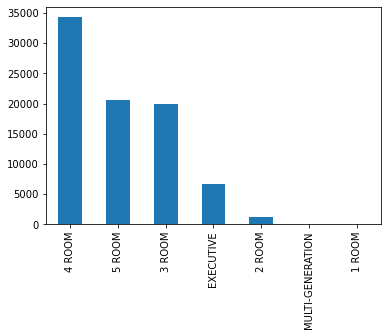

In [3]:
# Plot the bar chart of flat type
price.flat_type.value_counts().plot.bar()

To simplify the problem, it will be best to consider 4-Room Flat since it has the highest count.

In [4]:
# 4 Room flat is considered for the study

df = price.loc[price['flat_type'] == "4 ROOM"]

# Adding 'Block' is critical because some will not found in the cell
df['addresses'] = "Block " + price.block + " " + price.street_name + " " + "Singapore"

<ipython-input-4-352bfb26f034>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['addresses'] = "Block " + price.block + " " + price.street_name + " " + "Singapore"


In [5]:
#Reset the Index Number after the above filter
df = df.reset_index(drop=True)

#Statistic Summary
df.describe()

,floor_area_sqm,lease_commence_date,resale_price
count,34288.000000,34288.000000,3.428800e+04
mean,95.385622,1997.686158,4.350983e+05
std,7.236761,12.228888,1.199370e+05
min,70.000000,1967.000000,2.180000e+05
25%,91.000000,1987.000000,3.550000e+05
50%,93.000000,1998.000000,4.050000e+05
75%,102.000000,2011.000000,4.700000e+05
max,138.000000,2019.000000,1.186888e+06


The max and min resale price of 4-room have high difference of about a million. It might be due to lease date and floor area. 

Newer unit is seen to be more expensive than older unit since all HDB is having 99-year of lease period. A new feature called leftover yeas will be created. 

Bigger area will also One way to improve the dataset is to create a new feature - price per sqm at the aim to remove outliers. 

<AxesSubplot:>

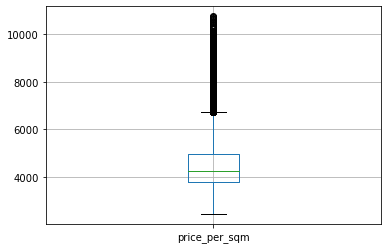

In [6]:
# 2 New Features

df['leftover_year'] = 99- (2020 - price.lease_commence_date.astype(int))

df['price_per_sqm'] = round(price.resale_price/price.floor_area_sqm,0)

df.describe()

df.boxplot(column=['price_per_sqm'] )

The outliers are found outside of the upper whisker which led to skew more to right in density plot that found below.  

<AxesSubplot:ylabel='Density'>

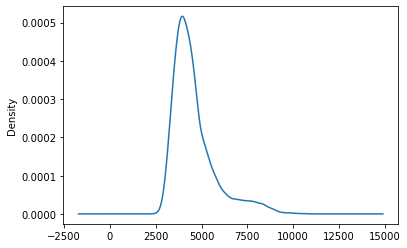

In [7]:
df.price_per_sqm.plot.density()

To increase significant association, it will be a good move to remove the outlier. The next step of data processing is to decide on significance level. Typically is either 95% or 90%.  

count    32571.000000
mean      4378.189985
std        875.465425
min       2439.000000
25%       3750.000000
50%       4214.000000
75%       4797.000000
max       7304.000000
Name: price_per_sqm, dtype: float64
median 4214.0


<AxesSubplot:>

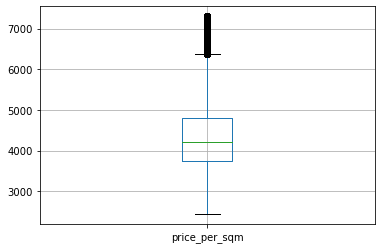

In [8]:
# significance level of 95% 

q5 = 5 

q5_hi = df["price_per_sqm"].quantile(1 - (q5/100))

q5 = df[(df["price_per_sqm"] < q5_hi)]
print(q5["price_per_sqm"].describe())
print('median ' + str(q5["price_per_sqm"].median()))

q5.boxplot(column=['price_per_sqm'] )


Outliers are still observed outside of the upper whisker. 

count    30858.000000
mean      4251.169940
std        704.009148
min       2439.000000
25%       3727.000000
50%       4164.000000
75%       4679.750000
max       6134.000000
Name: price_per_sqm, dtype: float64
median 4164.0


<AxesSubplot:>

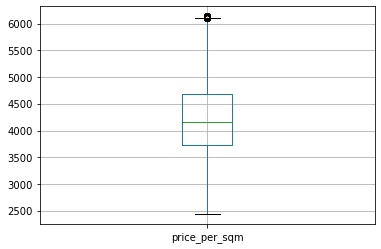

In [9]:
# significance level of 90% 

q10 = 10 
q10_hi = df["price_per_sqm"].quantile(1 - (q10/100))

q10 = df[(df["price_per_sqm"] < q10_hi)]
print(q10["price_per_sqm"].describe())
print('median ' + str(q10["price_per_sqm"].median()))

q10.boxplot(column=['price_per_sqm'] )

At 90% significance level, it has removed most of the ouliers in dataset 1. The values for mean and medium are nearer to each other.  

In [10]:
# Renumber the index again
df = q10.reset_index(drop=True)

# # Also transform the floor area into natural logarithm
df["Ln_resale_price"] = np.log(df['resale_price'])

# Drop the unneccesary features
df =df.drop(['resale_price','town','block','flat_type','flat_model','street_name'
         ,'month','lease_commence_date','remaining_lease','price_per_sqm' ],axis = 1)

Total number of json files: 30858

In [11]:
index_count = 30858

Extract each address from Googlemaps to save in the format of json. 
This is to extract 2 more feature latitude and longitude from json into the dataframe - dataset 1. 

In [12]:
#cautious: Takes 10min to run
import json
from shapely.geometry import Point, Polygon

for count in range(0,index_count):     
    
    # Extract from json file
    with open('data/addresses/index_' + str(count) + '.txt') as f:
        json_file = json.load(f)
        lng = json_file['geometry']['location']['lng']
        lat = json_file['geometry']['location']['lat']
        
        # convert from WSG84 to SVY21
        cv = SVY21()
        (N, E) = cv.computeSVY21(lat, lng)
        # Create Point objects
        geometry = Point(E, N)
        
        #Updated to dataframe: Dataset 1
        df.at[count,'lng'] = lng
        df.at[count,'lat'] = lat
        df.at[count,'geometry'] = str(geometry)

In [13]:
df.dtypes

storey_range        object
floor_area_sqm     float64
addresses           object
leftover_year        int32
Ln_resale_price    float64
lng                float64
lat                float64
geometry            object
dtype: object

Data Binning for: 

1. floor level
2. flat size
3. leasing year

1. floor level

df.storey_range to consider as the following:  

1. level 1 to 6 are low floor
2. level 7 to 9 are mid floor
3. level 10 to 21 are high floor
4. level 21 > are very high floor 


In [14]:
df["storey_range"].value_counts().sort_values(ascending=False)

04 TO 06    7035
07 TO 09    6500
10 TO 12    5785
01 TO 03    5338
13 TO 15    3051
16 TO 18    1420
19 TO 21     553
22 TO 24     432
25 TO 27     257
28 TO 30     180
34 TO 36      85
31 TO 33      81
37 TO 39      81
40 TO 42      39
46 TO 48      11
43 TO 45       6
49 TO 51       4
Name: storey_range, dtype: int64

In [15]:
# Create new column
df['floor_level'] = df['storey_range']

# Replace the string to low mid, high and vhigh
low = ['01 TO 03', '04 TO 06']
mid = ['07 TO 09']
high = ['10 TO 12','13 TO 15','16 TO 18','19 TO 21'], 
vhigh=['22 TO 24', '25 TO 27', '28 TO 30', '34 TO 36', '31 TO 33',
       '37 TO 39', '40 TO 42', '46 TO 48', '43 TO 45', '49 TO 51']

floor_range = low, mid, high, vhigh
floor_label = ['low', 'mid', 'high', 'vhigh']

for count in range(0,len(floor_range)):
    df['floor_level'] = df['floor_level'].replace(floor_range[count],floor_label[count])

2. flat size

In [16]:
# Qcut to create (near to) equal number of count in each bin 
df['flat_size'] = pd.qcut(df["floor_area_sqm"], q=4)
print(df['flat_size'].value_counts())
print("\n")

# Label the [(69.999, 91.0]<(91.0, 93.0]<(93.0, 103.0]<(103.0, 135.0] into ['small', 'medium', 'big', 'vbig']
df['flat_size'] = pd.qcut(df["floor_area_sqm"], q=4, labels= ['small', 'medium', 'big', 'vbig'])
print(df['flat_size'])

# Also transform the floor area into natural logarithm
import numpy as np
df["Ln_flat_size"] = np.log(df['floor_area_sqm'])

(69.999, 91.0]    8798
(91.0, 93.0]      8054
(93.0, 103.0]     7965
(103.0, 135.0]    6041
Name: flat_size, dtype: int64


0        medium
1         small
2           big
3        medium
4           big
          ...  
30853     small
30854      vbig
30855       big
30856     small
30857     small
Name: flat_size, Length: 30858, dtype: category
Categories (4, object): ['small' < 'medium' < 'big' < 'vbig']


3. Leasing Year

In [17]:
# Use cut to evenly spaced out the bin into [(44.951, 57.25] < (57.25, 69.5] < (69.5, 81.75] < (81.75, 94.0]]
df['leasing_year'] = pd.cut(df["leftover_year"], bins=4)
print(df['leasing_year'].value_counts())
print("\n")

df['leasing_year'] = pd.cut(df["leftover_year"], bins=4, labels = ['short', 'moderate', 'long', 'vlong'])
df['leasing_year'].sort_index()

# Also transform the lefover_year into natural logarithm
import numpy as np
df["Ln_leasing_year"] = np.log(df['leftover_year'])

(57.25, 69.5]      11387
(69.5, 81.75]       9836
(81.75, 94.0]       5828
(44.951, 57.25]     3807
Name: leasing_year, dtype: int64




In [18]:
# Drop the unneccseary features
df =df.drop(['storey_range','floor_area_sqm','leftover_year','addresses', 'lat', 'lng' ],axis = 1)

To change Dataset 1  from df to gdf where gdf is the format of GeoDataframe. 

In [19]:
from shapely import wkt
import geopandas as gpd


for i in range(0,1):
    try: 
        df.geometry= df.geometry.apply(wkt.loads)  
    except:
        break

gdf = gpd.GeoDataFrame(df, geometry='geometry')

To check if geometry has successfully converted  for data type from object to geometry.

In [20]:
gdf.dtypes

Ln_resale_price     float64
geometry           geometry
floor_level          object
flat_size          category
Ln_flat_size        float64
leasing_year       category
Ln_leasing_year     float64
dtype: object

In [21]:
gdf.head()

,Ln_resale_price,geometry,floor_level,flat_size,Ln_flat_size,leasing_year,Ln_leasing_year
0,12.899220,POINT (30756.192 38359.100),high,medium,4.521789,moderate,4.060443
1,12.899220,POINT (30592.365 38305.381),mid,small,4.510860,short,4.043051
2,12.906692,POINT (28790.358 40233.918),low,big,4.543295,moderate,4.077537
3,12.923912,POINT (30611.896 39498.042),low,medium,4.521789,moderate,4.077537
4,12.961932,POINT (28941.568 39228.328),low,big,4.584967,moderate,4.077537


# Step 3: New Features - Distance from CBD and Walking Distance from MRT

2 sets of Datasets will be in shapefile format and extracted from 
https://data.gov.sg/dataset/master-plan-2014-planning-area-boundary-no-sea
https://www.mytransport.sg/content/mytransport/home/dataMall/static-data.html

The dataset will be represented as b_map (boundary map) and .

In [22]:
# Convert data type from geometery to float to include annotate in the plot  
import re

def geotofloat(a):
    z= a.centroid.astype(str)
    x = re.split(" ",z[0])[1][1:]
    y = re.split(" ",z[0])[2][:-1]
    return [float(x),float(y)]

In [23]:
import geopandas as gpd

shapefile_MRT = "data/MRTLRTStnPtt.shp"
b_map_MRT = gpd.read_file(shapefile_MRT)

shapefile_singapore = "data/MP14_PLNG_AREA_NO_SEA_PL.shp"
b_map_singapore = gpd.read_file(shapefile_singapore)

Text(0.5, 1.0, 'Singapore Map with MRT')

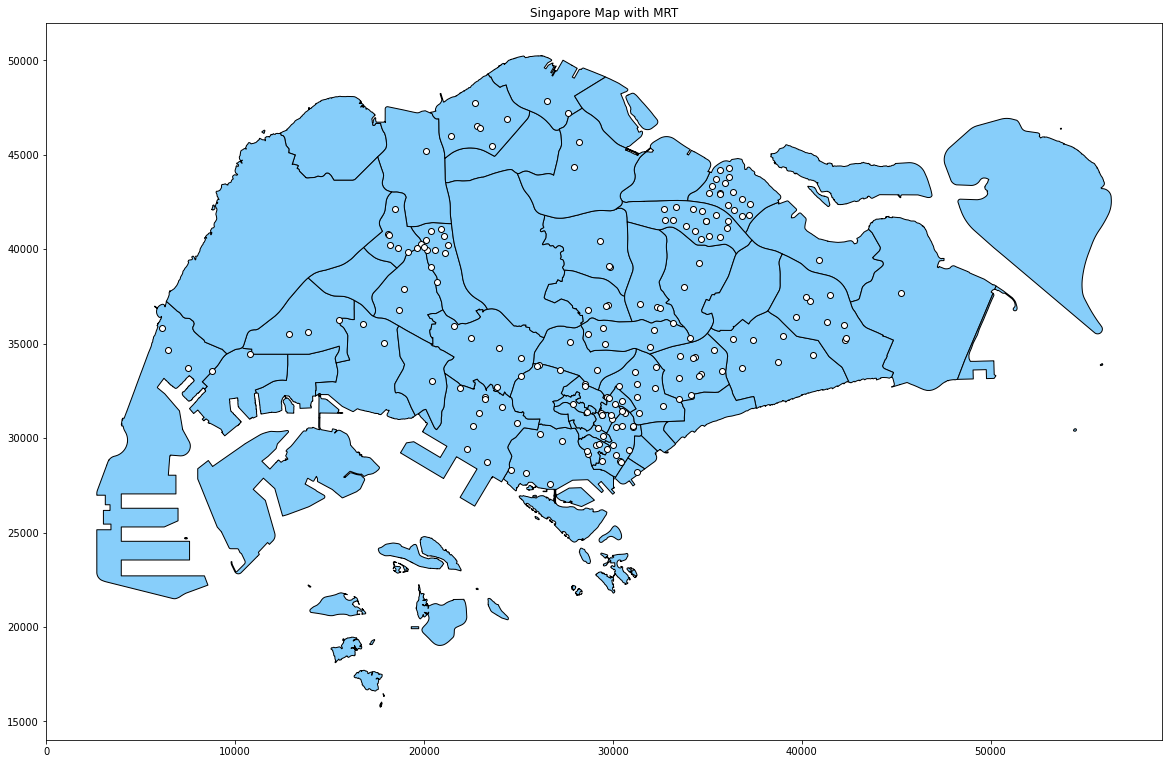

In [24]:
#plot Singapore map with MRT
import matplotlib.pyplot as plt
ax = b_map_singapore.plot(color='lightskyblue',edgecolor = 'black', figsize = (20,20))
b_map_MRT.plot(ax = ax, color = 'white', edgecolor = 'black').set_title('Singapore Map with MRT')

In [25]:
# Refer to Question 1 on how to pick for CBD

from shapely.ops import cascaded_union
import matplotlib.pyplot as plt
import re

CBD_Districts = ['MUSEUM','NEWTON','SINGAPORE RIVER','ORCHARD','RIVER VALLEY']
boundary = b_map_singapore.query('PLN_AREA_N in @CBD_Districts')

# Union polygons together 
polygons = [poly for poly in boundary.geometry]
CBD_map = gpd.GeoSeries(cascaded_union(polygons))

#Defining 5, 10, 15km radius at the center of CBD
radius_5km = CBD_map.centroid.buffer(5000)
radius_10km = CBD_map.centroid.buffer(10000)
radius_15km = CBD_map.centroid.buffer(15000)
radius_20km = CBD_map.centroid.buffer(20000)

In [26]:
from shapely.geometry import Point, Polygon

for i in range(0,len(gdf)):
    gdf.at[i,'CBD_radius_5km'] = gdf.geometry[i].within(radius_5km[0])
    gdf.at[i,'CBD_radius_10km'] = gdf.geometry[i].within(radius_10km[0])
    gdf.at[i,'CBD_radius_15km'] = gdf.geometry[i].within(radius_15km[0])
    gdf.at[i,'CBD_radius_20km']= gdf.geometry[i].within(radius_20km[0])
     

<AxesSubplot:title={'center':'CBD Distance'}>

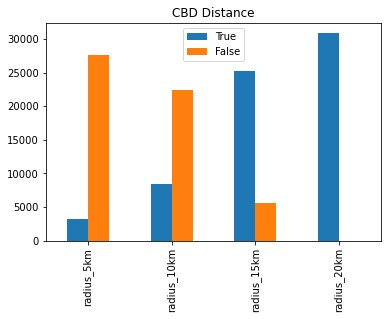

In [27]:
Radius_False = [dict(gdf.CBD_radius_5km.value_counts())[False], dict(gdf.CBD_radius_10km.value_counts())[False],
               dict(gdf.CBD_radius_15km.value_counts())[False],0]
Radius_True = [dict(gdf.CBD_radius_5km.value_counts())[True], dict(gdf.CBD_radius_10km.value_counts())[True],
               dict(gdf.CBD_radius_15km.value_counts())[True],dict(gdf.CBD_radius_20km.value_counts())[True]]

Radius_index = ['radius_5km', 'radius_10km', 'radius_15km', 'radius_20km']

pd.DataFrame({'True': Radius_True, 'False': Radius_False}, index=Radius_index).plot.bar(title='CBD Distance')

All the addresses are fall within 20km from CBD

In [28]:
# Convert data type from geometery to float to include annotate in the plot  
def geotofloat(a):
    z = str(a)
    x = re.split(" ",z)[1][1:]
    y = re.split(" ",z)[2][:-1]
    return [float(x),float(y)]

# Find Euclidean distance; Also transform into natural logarithm
for i in range(0,len(gdf)):
    gdf.at[i,"Ln_distance_from_CBD"] =  math.log(math.dist(geotofloat(CBD_map.centroid[0]), geotofloat(gdf.geometry[i]))) 

In [47]:
from shapely.geometry import Point, Polygon

for i in range(0, len(gdf)):
    distance = 50000 # initilise an impossible MRT distance of 50km 
    for j in range(0,len(b_map_MRT)):
        radius_500m = b_map_MRT.geometry[j].centroid.buffer(500)
        radius_1000m = b_map_MRT.geometry[j].centroid.buffer(1000)
        if gdf.geometry[i].within(radius_1000m) is True:
            gdf.at[i,'MRT_radius_1000m']= 'True' 
        if gdf.geometry[i].within(radius_500m) is True:
            gdf.at[i,'MRT_radius_500m']= 'True'
        
        distance1 = math.dist(geotofloat(b_map_MRT.geometry[j]), geotofloat(gdf.geometry[i]))
        if distance1 < distance:
            distance = distance1
        gdf.at[i,'Ln_distance_from_nearest_MRT'] = distance
                

gdf['MRT_radius_500m'] = gdf['MRT_radius_500m'].fillna('False')
gdf['MRT_radius_1000m'] = gdf['MRT_radius_1000m'].fillna('False')
gdf['Ln_distance_from_nearest_MRT'] = np.log(df['Ln_distance_from_nearest_MRT'])

In [48]:
#Convert to one-hot encoder 
gdf_onehot = pd.get_dummies(gdf, columns=['flat_size','floor_level','leasing_year','CBD_radius_5km','CBD_radius_10km',
                            'CBD_radius_15km', 'CBD_radius_20km','MRT_radius_500m','MRT_radius_1000m'])

In [49]:
# Drop the unneccessary 
gdf_onehot = gdf_onehot.drop(['geometry'],axis = 1)
    
# Final Dataframe
gdf_onehot.head()

,Ln_resale_price,Ln_flat_size,Ln_leasing_year,Ln_distance_from_CBD,Ln_distance_from_nearest_MRT,flat_size_small,flat_size_medium,flat_size_big,flat_size_vbig,floor_level_high,...,CBD_radius_5km_True,CBD_radius_10km_False,CBD_radius_10km_True,CBD_radius_15km_False,CBD_radius_15km_True,CBD_radius_20km_True,MRT_radius_500m_False,MRT_radius_500m_True,MRT_radius_1000m_False,MRT_radius_1000m_True
0,12.899220,4.521789,4.060443,8.886820,7.034301,0,1,0,0,1,...,0,0,1,0,1,1,1,0,1,0
1,12.899220,4.510860,4.043051,8.872871,6.952555,1,0,0,0,0,...,0,0,1,0,1,1,1,0,1,0
2,12.906692,4.543295,4.077537,9.078249,6.281671,0,0,1,0,0,...,0,0,1,0,1,1,1,0,0,1
3,12.923912,4.521789,4.077537,9.022734,6.790484,0,1,0,0,0,...,0,0,1,0,1,1,1,0,0,1
4,12.961932,4.584967,4.077537,8.957272,6.773457,0,0,1,0,0,...,0,0,1,0,1,1,1,0,0,1


In [50]:
# Final Dataframe
print(gdf_onehot.describe())

print(gdf_onehot.dtypes)


       Ln_resale_price  Ln_flat_size  Ln_leasing_year  Ln_distance_from_CBD  \
count     30858.000000  30858.000000     30858.000000          30858.000000   
mean         12.950921      4.555293         4.251674              9.259452   
std           0.243532      0.075701         0.164461              0.485374   
min          12.292250      4.248495         3.806662              7.298573   
25%          12.779873      4.510860         4.143135              9.127070   
50%          12.911642      4.532599         4.262680              9.426754   
75%          13.060488      4.634729         4.382027              9.561851   
max          13.986845      4.905275         4.543295              9.782092   

       Ln_distance_from_nearest_MRT  flat_size_small  flat_size_medium  \
count                  30858.000000     30858.000000      30858.000000   
mean                       6.188067         0.285112          0.261002   
std                        0.705150         0.451475          0.43

# Step 4: Regression Model 

In [51]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn import metrics
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score

In [52]:
#Identify Features and Class Label

X = gdf_onehot.drop(['Ln_resale_price'],axis = 1)
Y = pd.DataFrame(gdf_onehot['Ln_resale_price'])

#Split Data into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [53]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

# step-1: create a cross-validation scheme
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

# step-2: specify range of hyperparameters to tune
hyper_params = [{'n_features_to_select': list(range(1, 27))}]


# step-3: perform grid search
# 3.1 specify model
lm = LinearRegression()
lm.fit(X_train, Y_train)  
rfe = RFE(lm)             

# 3.2 call GridSearchCV()
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train, Y_train)           

Fitting 5 folds for each of 26 candidates, totalling 130 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed:   23.0s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=RFE(estimator=LinearRegression()),
             param_grid=[{'n_features_to_select': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14, 15, 16,
                                                   17, 18, 19, 20, 21, 22, 23,
                                                   24, 25, 26]}],
             return_train_score=True, scoring='r2', verbose=1)

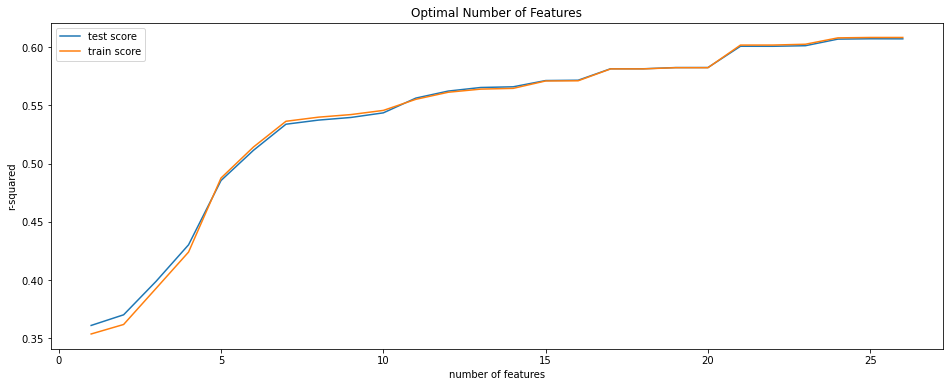

In [54]:
cv_results = pd.DataFrame(model_cv.cv_results_)

# plotting cv results
plt.figure(figsize=(16,6))

plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')

In [55]:
# final model
n_features_optimal = model_cv.best_index_

lm = LinearRegression()
lm.fit(X_train, Y_train)

rfe = RFE(lm, n_features_to_select=n_features_optimal)             
rfe = rfe.fit(X_train, Y_train)

# predict prices for training & testing 
Y_pred_train = lm.predict(X_train)
Y_pred_test = lm.predict(X_test)

#Results
# Check the predictions against the actual values by using the MSE and R-2 metrics:
print("\nTraining RMSE:", round(mean_squared_error(Y_train, Y_pred_train),4))
print("Validation RMSE:", round(mean_squared_error(Y_test, Y_pred_test),4))
print("\nTraining r2:", round(r2_score(Y_train, Y_pred_train),3))
print("Validation r2:", round(r2_score(Y_test, Y_pred_test),3))


Training RMSE: 0.0232
Validation RMSE: 0.024

Training r2: 0.608
Validation r2: 0.594


In [65]:
# Regression coefficients and intercept
print(pd.Series(lm.coef_[0], index= X.columns))
print(pd.Series(lm.intercept_[0], index= ['intercept']))

Ln_flat_size                    4.979392e-01
Ln_leasing_year                -7.887286e-03
Ln_distance_from_CBD           -2.942612e-01
Ln_distance_from_nearest_MRT   -2.575399e-02
flat_size_small                -1.257533e+11
flat_size_medium               -1.257533e+11
flat_size_big                  -1.257533e+11
flat_size_vbig                 -1.257533e+11
floor_level_high               -9.827417e+10
floor_level_low                -9.827417e+10
floor_level_mid                -9.827417e+10
floor_level_vhigh              -9.827417e+10
leasing_year_short              1.441516e+11
leasing_year_moderate           1.441516e+11
leasing_year_long               1.441516e+11
leasing_year_vlong              1.441516e+11
CBD_radius_5km_False           -2.161268e+10
CBD_radius_5km_True            -2.161268e+10
CBD_radius_10km_False           1.916187e+12
CBD_radius_10km_True            1.916187e+12
CBD_radius_15km_False          -5.803352e+11
CBD_radius_15km_True           -5.803352e+11
CBD_radius